# Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import linear_model, model_selection, metrics, pipeline, preprocessing
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Зазрузка данных

In [3]:
raw_data=pd.read_csv('bike_sharing_demand.csv')
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


__datetime__ - hourly date + timestamp

__season__ - 1 = spring, 2 = summer, 3 = fall, 4 = winter

__holiday__ - whether the day is considered a holiday

__workingday__ - whether the day is neither a weekend nor holiday

__weather__ - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

__temp__ - temperature in Celsius

__atemp__ - "feels like" temperature in Celsius

__humidity__ - relative humidity

__windspeed__ - wind speed

__casual__ - number of non-registered user rentals initiated

__registered__ - number of registered user rentals initiated

__count__ - number of total re

In [4]:
raw_data.shape

(10886, 12)

In [5]:
raw_data.isnull().values.any()

False

### Предобработка данных
#### Типы признаков

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [8]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [9]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


#### Обучение и отложенный тест

In [10]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [11]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [12]:
print ('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print ('test period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
test period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

In [13]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [14]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Целевая функция на обучающей выборке и на отложенном тесте

Text(0.5, 1.0, 'test data')

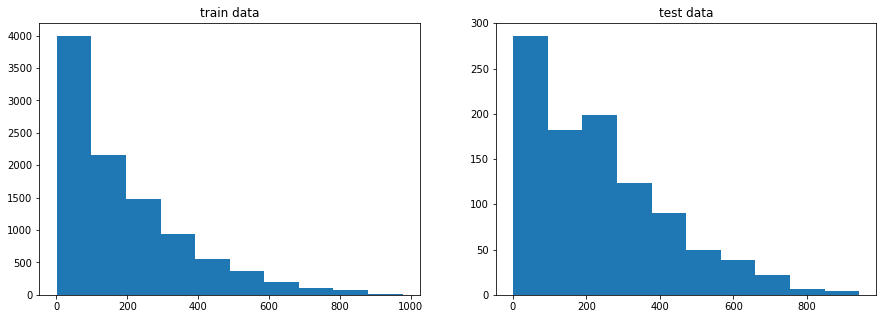

In [15]:
pylab.figure(figsize=(15,5))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Числовые признаки

In [16]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [17]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [18]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [19]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Модель

In [20]:
regressor=linear_model.SGDRegressor(random_state=0, max_iter=5)
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 5,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [21]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

31851310300813.895

In [22]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [23]:
print(regressor.predict(test_data)[:10])

[6.38237236e+13 9.93774167e+13 4.50263651e+13 3.24238509e+13
 3.17252459e+13 4.39305995e+13 4.44982989e+13 4.41783289e+13
 4.68904479e+13 5.83210989e+13]


In [24]:
regressor.coef_

array([ 1.51022653e+11, -5.06697186e+10,  4.53044112e+10, -7.46986340e+10,
        1.80525319e+11,  1.10015690e+11, -3.01811345e+09,  8.39465294e+10])

Очень большие коэффициенты обьясняют такое большое значение ошибки. Для того чтобы решить эту проблему, нужно отмасштабировать признаки в наборе данных.

### Scaling

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler=StandardScaler()

In [27]:
scaler.fit(train_data, train_labels)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
scaled_train_data=scaler.transform(train_data)
scaled_test_data=scaler.transform(test_data)

In [29]:
regressor.fit(scaled_train_data, train_labels)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=5,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=0,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [30]:
metrics.mean_absolute_error(regressor.predict(scaled_test_data),test_labels)

0.11793762963431477

In [31]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [32]:
print(regressor.predict(scaled_test_data)[:10])

[524.82767322 834.83176277 354.85768824 221.89221002 227.84049612
 324.88196372 327.8982227  307.9347954  345.90146969 445.90141764]


In [33]:
regressor.coef_

array([ 1.41019246e+00, -1.40725539e+00,  1.45346928e-02, -4.38984175e-02,
        5.08589954e+01,  1.48004811e+02, -8.23376876e-03,  6.37720415e-03])

In [34]:
list(map(lambda x: round(x,2), regressor.coef_))

[1.41, -1.41, 0.01, -0.04, 50.86, 148.0, -0.01, 0.01]

In [35]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [36]:
train_labels[:5]

array([16, 40, 32, 13,  1], dtype=int64)

In [37]:
np.any(train_data.registered + train_data.casual == train_labels)

True

Практически все признаки принимают очень маленькие веса, за исключением двух: casual (количество незарегистрированных пользователей) и registered (зарегистрированных).
Эти два столбца в сумме дают целевую метку. Поэтомус набора данных их нужно удалить, и заново отмасштабировать и обучить набор данных.

In [38]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [39]:
scaler.fit(train_data, train_labels)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
scaled_train_data=scaler.transform(train_data)
scaled_test_data=scaler.transform(test_data)

In [41]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(regressor.predict(scaled_test_data), test_labels)

121.81123864993025

In [42]:
list(map(lambda x: round(x,2), regressor.coef_))

[31.03, 29.96, -41.93, 6.17, 14.08, 49.6]

Фактически получили базовую модель, некоторый baseline, который считаем правильным. Теперь попытаемся его улучшить, подобрав оптимальные параметры.
Чтобы было проще работать с несколькими преобразованиями (масштабирование и кросс-валидация) можно воспользоваться Pipeline.
### Pipeline

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [45]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(pipeline.predict(test_data), test_labels)

121.81123864993025

### Подбор параметров

In [46]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [47]:
parameters_grid={
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [48]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [49]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 10.6 s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regression',
                                        SGDRegressor(alpha=0.0001,
                                                     average=False,
                                                     early_stopping=False,
                                                     epsilon=0.1, eta0=0.01,
                                                     fit_intercept=True,
                                                     l1_ratio=0.15,
                                                     learning_rate='invscaling',
                                                     loss='squared_loss',
      

In [50]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.61449660348289
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


### Оценка по отложенному тесту

In [51]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935378

In [52]:
np.mean(test_labels)

232.159

Видим, что среднее значение — 232 велосипеда, но при этом ошибаемся на 120.
И с этой точки зрения 122 от 120 отличаются не очень сильно. Фактически оптимизация с помощью подбора параметров не помогла улучшить модель.

In [53]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [54]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [55]:
print(test_predictions[:10])

[139.60470681 159.80765341 207.55935972 237.76288054 257.83836668
 267.44558034 272.49537469 297.70688522 304.29818873 313.58821156]


(-100, 1100)

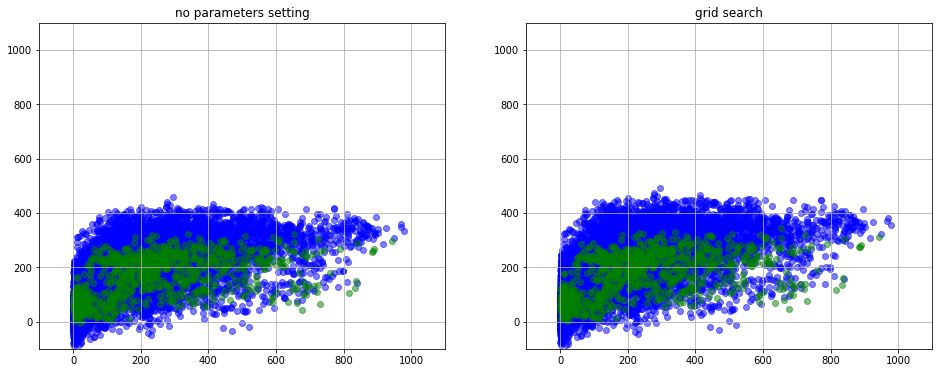

In [56]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'blue')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'green')
pylab.title('no parameters setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'blue')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'green')
pylab.title('grid search')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

Для хорошей модели ожидаем облако точек в районе диагонали (предсказания должны совпадать с целевой меткой, поэтому должна получиться диагональ).
В данном случае имеем не очень хорошую модель, облака точек совсем не похожи на диагональ. Более того, облака точек при использовании модели без подбора параметров и облака точек при использовании модели с подбором параметров не сильно отличаются. Поэтому необходимо обработать все признаки.

### Предобработка данных
#### Обучение и отложенный тест

In [57]:
raw_data.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


In [58]:
train_data=raw_data.iloc[:-1000]
hold_out_test_data = raw_data.iloc[-1000:]
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [59]:
# обучение
train_labels=train_data['count'].values
train_data=train_data.drop(['datetime', 'casual', 'registered', 'count'], axis=1)

In [60]:
# тест
test_labels=hold_out_test_data['count'].values
test_data=hold_out_test_data.drop(['datetime', 'casual', 'registered', 'count'], axis=1)

In [61]:
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,1
2,1,0,0,1,9.02,13.635,80,0.0,1,2
3,1,0,0,1,9.84,14.395,75,0.0,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,4


Разделим данные по типам. Получим некоторый логический индекс, который будет показывать, в каком столбце находятся данные данного типа (индекс будет принимать значение True в позиции нужных столбцов).
1.	Сделаем это для бинарных признаков: holiday (1 – выходной, 0 – рабочий день) и workingday (1 – рабочий, 0 – выходной)

In [62]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [63]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


2. Сделаем это для категориальных признаков: season, weather, month

In [64]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices =np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [65]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


3. Сделаем это для чисденных признаков

In [66]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [67]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [68]:
regressor=linear_model.SGDRegressor(random_state=0, max_iter=3, loss='squared_loss', penalty='l2')

In [69]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

In [70]:
estimator=Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        #binary
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, binary_data_indices])),
        #numeric
        ('numeric_variables_processing', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:, numeric_data_indices])),
            ('scaling', StandardScaler(with_mean=0))
        ])),
        #catgorical
        ('categorical_variables_processing', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('model_fitting', regressor)
])

In [71]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001FB22846598>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [72]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806856

### Подбор параметров

In [73]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 

In [74]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [75]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [76]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 1.09 s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x000001FB22846598>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                      

In [77]:
grid_cv.best_score_


-106.60193979729921

In [78]:
grid_cv.best_params_

{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}

### Оценка по отложенному тесту

In [79]:
test_predictions=grid_cv.best_estimator_.predict(test_data)

In [80]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [81]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [82]:
test_predictions[:10]

array([153.28859124, 181.89867268, 227.64068051, 262.47727954,
       278.91095558, 279.82091706, 301.6223314 , 333.35079391,
       336.28447325, 348.55425173])

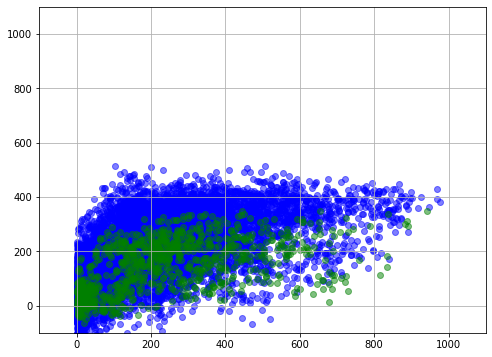

In [83]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'blue')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'green')

Все преобразования — генерация новых признаков, вновь подбор параметров — не привели к улучшению модели.
Причина в том, что была построена линейная модель (предполагается, что есть некоторая линейная зависимость между признаками и целевой переменной). На самом деле это не совсем так. 
Решение:
1.	Генерация других признаков (признаков,  на которых такая зависимость будет предполагаться). 
2.	Использование более сложной модели, что умеет учитывать нелинейные зависимости между признаками и целевой функцией. 

### Использование модели 'Случайный лес'

In [84]:
from sklearn.ensemble import RandomForestRegressor

In [85]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [86]:
estimator=Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        #binary
        ('binary_variables_processing', FunctionTransformer(lambda data: data[:, binary_data_indices])),
        #numeric
        ('numeric_variables_processing', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:, numeric_data_indices])),
            ('scaling', StandardScaler(with_mean=0))
        ])),
        #catgorical
        ('categorical_variables_processing', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('model_fitting', regressor)
])

In [87]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001FB22F286A8>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [88]:
metrics.mean_absolute_error(estimator.predict(test_data), test_labels)

79.49758619912876

In [89]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [90]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

Text(0.5, 1.0, 'random forest model')

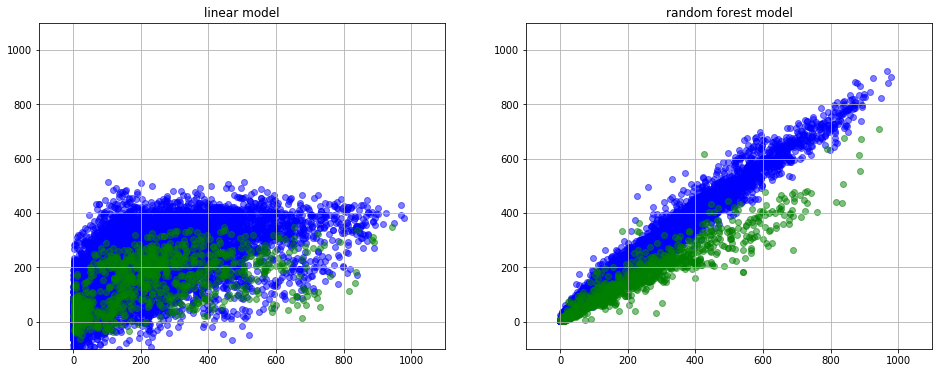

In [91]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'blue')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'green')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'blue')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'green')
pylab.title('random forest model')

Видим, что в данном случае объекты достаточно близко подошли к диагональной области. 
То бишь, с помощью этой модели получилось гораздо лучше установить зависимость. 